In [15]:
#visualization libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from IPython.display import Image
import plotly.express as px
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.offline as pyo
from plotly import tools
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
import time


#data preprocessing & modelling libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
#from yellowbrick.cluster import KElbowVisualizer
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics

pyo.init_notebook_mode()

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [16]:
marketing_data=pd.read_csv('marketing_campaign.csv',sep='\t')
marketing_data.shape

(2240, 29)

In [17]:
marketing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [18]:
total = marketing_data.isnull().sum().sort_values(ascending=False)
percent = ((marketing_data.isnull().sum()/marketing_data.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total,percent],axis=1, keys=["Total","Percent"])

In [19]:
missing_data[missing_data['Total']>0]

Total   Percent
Income     24  1.071429

<AxesSubplot:title={'center':'Income'}, xlabel='Income'>

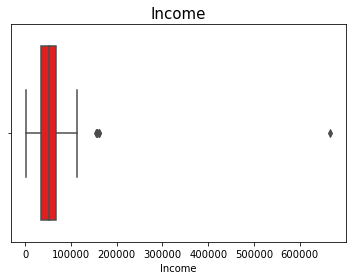

In [20]:
plt.title('Income',size=15)
sns.boxplot(x='Income',data=marketing_data,color='red')

In [21]:
marketing_data['Income']= marketing_data['Income'].fillna(marketing_data['Income'].median())
marketing_data['Income'].isna().sum()

0

In [22]:
marketing_data=marketing_data.dropna()

In [23]:
unique_counts = pd.DataFrame.from_records([(col, marketing_data[col].nunique()) for col in marketing_data.columns],
                          columns=['columns', 'unique_values']).sort_values(by=['unique_values'])
unique_counts

columns  unique_values
27            Z_Revenue              1
26        Z_CostContact              1
28             Response              2
20         AcceptedCmp3              2
21         AcceptedCmp4              2
24         AcceptedCmp2              2
25             Complain              2
23         AcceptedCmp1              2
22         AcceptedCmp5              2
5               Kidhome              3
6              Teenhome              3
2             Education              5
3        Marital_Status              8
17  NumCatalogPurchases             14
18    NumStorePurchases             14
15    NumDealsPurchases             15
16      NumWebPurchases             15
19    NumWebVisitsMonth             16
1            Year_Birth             59
8               Recency            100
10            MntFruits            158
13     MntSweetProducts            177
12      MntFishProducts            182
14         MntGoldProds            213
11      MntMeatProducts            558
7           Dt_Customer            663
9              MntWines            776
4                Income           1975
0                    ID           2240

In [24]:
print(marketing_data.Z_Revenue.nunique())
print(marketing_data.Z_CostContact.nunique())
#Drop these columns off

1
1


In [25]:
print("Total categories in the feature Marital_Status:\n", marketing_data["Marital_Status"].value_counts(), "\n")

Total categories in the feature Marital_Status:
 Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 



In [26]:
print("Total categories in the feature Education:\n", marketing_data["Education"].value_counts())

Total categories in the feature Education:
 Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64


In [27]:
#astyping Dt_Customer column as datetime object.
marketing_data["Dt_Customer"] = pd.to_datetime(marketing_data["Dt_Customer"])

#age of customer
marketing_data["Age"]=2021-marketing_data.Year_Birth

#Replacing the conflict values in marital status
marketing_data['Marital_Status'] = marketing_data['Marital_Status'].replace(['Married', 'Together'],'Relationship')
marketing_data['Marital_Status'] = marketing_data['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'],'Single')

#Feature indicating total children living in the household
marketing_data["Children"]=marketing_data["Kidhome"]+marketing_data["Teenhome"]

#Feature for total members in the household
marketing_data["Family_Size"] = marketing_data["Marital_Status"].replace({"Single": 1, "Relationship":2})+ marketing_data["Children"]

#Feature pertaining parenthood
marketing_data["Is_Parent"] = np.where(marketing_data.Children> 0, 1, 0)

#Segmenting education levels in three groups
marketing_data["Education"]=marketing_data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
marketing_data=marketing_data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Total spendings
marketing_data["Spent"] = marketing_data["Wines"]+ marketing_data["Fruits"]+ marketing_data["Meat"]+ marketing_data["Fish"]+ marketing_data["Sweets"]+ marketing_data["Gold"]

#Total Accepted Campaigns
marketing_data['Accepted_Campaigns'] = marketing_data['AcceptedCmp1'] + marketing_data['AcceptedCmp2'] + marketing_data['AcceptedCmp3'] + marketing_data['AcceptedCmp4'] + marketing_data['AcceptedCmp5']

#Number of Total Purchases
marketing_data['Total_Purchases'] = marketing_data['NumWebPurchases'] + marketing_data['NumCatalogPurchases'] + marketing_data['NumStorePurchases'] + marketing_data['NumDealsPurchases']

#Marital Status 2
def marital_status_2(row):
    if row["Is_Parent"] == 1:
        return "Family with Children"
    if row["Marital_Status"] == "Relationship" and row["Is_Parent"] == 0:
        return "Relationship"
    else:
        return "Single"

marketing_data["Marital_Status_2"] = marketing_data.apply(lambda row: marital_status_2(row), axis=1)  
marketing_data['First_day'] = '01-01-2015'
marketing_data['First_day'] = pd.to_datetime(marketing_data.First_day)
marketing_data['Day_engaged'] = (marketing_data['First_day'] - marketing_data['Dt_Customer']).dt.days

In [28]:
cols = ["Dt_Customer", "Z_CostContact","First_day", "Z_Revenue", "Year_Birth", "ID"]
marketing_data = marketing_data.drop(cols, axis=1)

In [29]:
marketing_data = marketing_data[(marketing_data["Age"]<90)]
marketing_data = marketing_data[(marketing_data["Income"]<600000)]

In [30]:
marketing_data.describe().transpose()

count          mean           std     min       25%  \
Income               2236.0  51952.614043  21411.466851  1730.0  35502.50   
Kidhome              2236.0      0.444097      0.538459     0.0      0.00   
Teenhome             2236.0      0.506708      0.544609     0.0      0.00   
Recency              2236.0     49.116279     28.957284     0.0     24.00   
Wines                2236.0    304.127460    336.591810     0.0     24.00   
Fruits               2236.0     26.275939     39.724007     0.0      1.00   
Meat                 2236.0    166.983453    225.689645     0.0     16.00   
Fish                 2236.0     37.536225     54.648562     0.0      3.00   
Sweets               2236.0     27.080501     41.299504     0.0      1.00   
Gold                 2236.0     43.983005     52.061568     0.0      9.00   
NumDealsPurchases    2236.0      2.326029      1.933032     0.0      1.00   
NumWebPurchases      2236.0      4.087657      2.779988     0.0      2.00   
NumCatalogPurchases  2236.0      2.663238      2.923898     0.0      0.00   
NumStorePurchases    2236.0      5.795617      3.251129     0.0      3.00   
NumWebVisitsMonth    2236.0      5.318873      2.426886     0.0      3.00   
AcceptedCmp3         2236.0      0.072898      0.260027     0.0      0.00   
AcceptedCmp4         2236.0      0.074687      0.262944     0.0      0.00   
AcceptedCmp5         2236.0      0.072451      0.259291     0.0      0.00   
AcceptedCmp1         2236.0      0.064401      0.245520     0.0      0.00   
AcceptedCmp2         2236.0      0.013417      0.115077     0.0      0.00   
Complain             2236.0      0.008945      0.094173     0.0      0.00   
Response             2236.0      0.149374      0.356536     0.0      0.00   
Age                  2236.0     52.101968     11.703281    25.0     44.00   
Children             2236.0      0.950805      0.752204     0.0      0.00   
Family_Size          2236.0      2.595707      0.907468     1.0      2.00   
Is_Parent            2236.0      0.715116      0.451460     0.0      0.00   
Spent                2236.0    605.986583    601.865156     5.0     69.00   
Accepted_Campaigns   2236.0      0.297853      0.678737     0.0      0.00   
Total_Purchases      2236.0     14.872540      7.677874     0.0      8.00   
Day_engaged          2236.0    538.179785    232.311073    26.0    366.75   

                         50%       75%       max  
Income               51381.5  68275.75  162397.0  
Kidhome                  0.0      1.00       2.0  
Teenhome                 0.0      1.00       2.0  
Recency                 49.0     74.00      99.0  
Wines                  174.0    504.25    1493.0  
Fruits                   8.0     33.00     199.0  
Meat                    67.0    232.00    1725.0  
Fish                    12.0     50.00     259.0  
Sweets                   8.0     33.00     263.0  
Gold                    24.0     56.00     362.0  
NumDealsPurchases        2.0      3.00      15.0  
NumWebPurchases          4.0      6.00      27.0  
NumCatalogPurchases      2.0      4.00      28.0  
NumStorePurchases        5.0      8.00      13.0  
NumWebVisitsMonth        6.0      7.00      20.0  
AcceptedCmp3             0.0      0.00       1.0  
AcceptedCmp4             0.0      0.00       1.0  
AcceptedCmp5             0.0      0.00       1.0  
AcceptedCmp1             0.0      0.00       1.0  
AcceptedCmp2             0.0      0.00       1.0  
Complain                 0.0      0.00       1.0  
Response                 0.0      0.00       1.0  
Age                     51.0     62.00      81.0  
Children                 1.0      1.00       3.0  
Family_Size              3.0      3.00       5.0  
Is_Parent                1.0      1.00       1.0  
Spent                  396.5   1045.50    2525.0  
Accepted_Campaigns       0.0      0.00       4.0  
Total_Purchases         15.0     21.00      44.0  
Day_engaged            539.0    712.00    1089.0

<AxesSubplot:xlabel='Response', ylabel='count'>

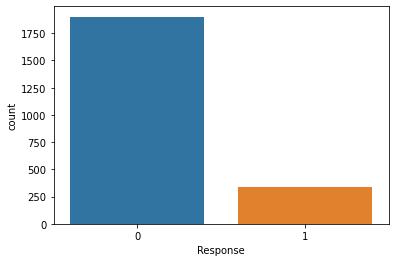

In [31]:
sns.countplot(marketing_data.Response)

In [25]:
marketing_data['Income'].median()

51381.5

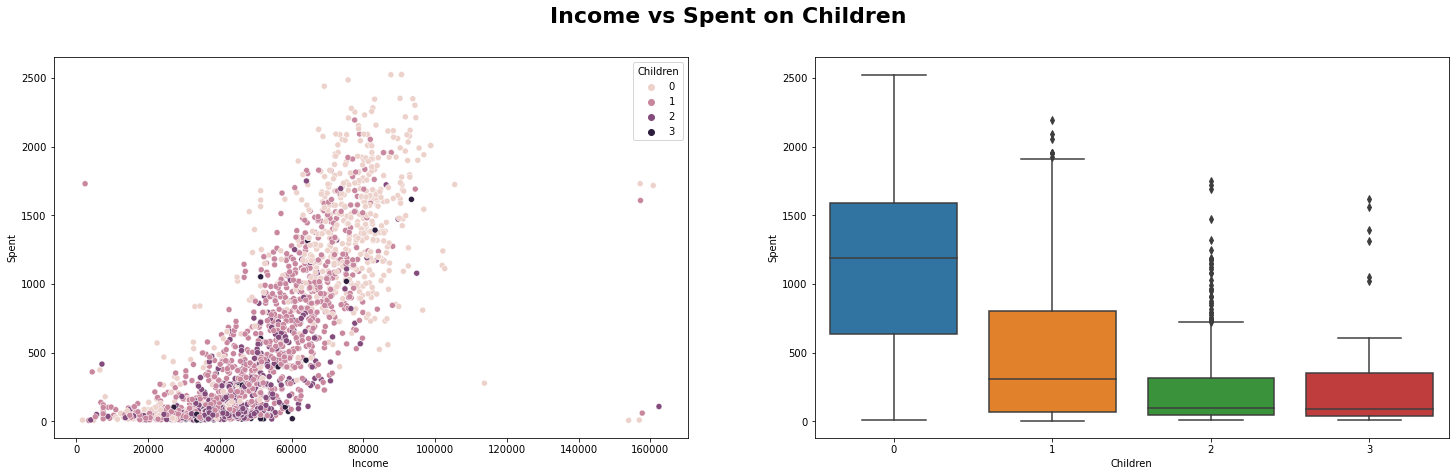

In [45]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,7))
fig.suptitle("Income vs Spent on Children",size=22,weight="bold")


sns.scatterplot(x="Income",y="Spent",data=marketing_data, hue="Children", ax=ax1)

sns.boxplot(x="Children",y="Spent",data=marketing_data, ax=ax2);

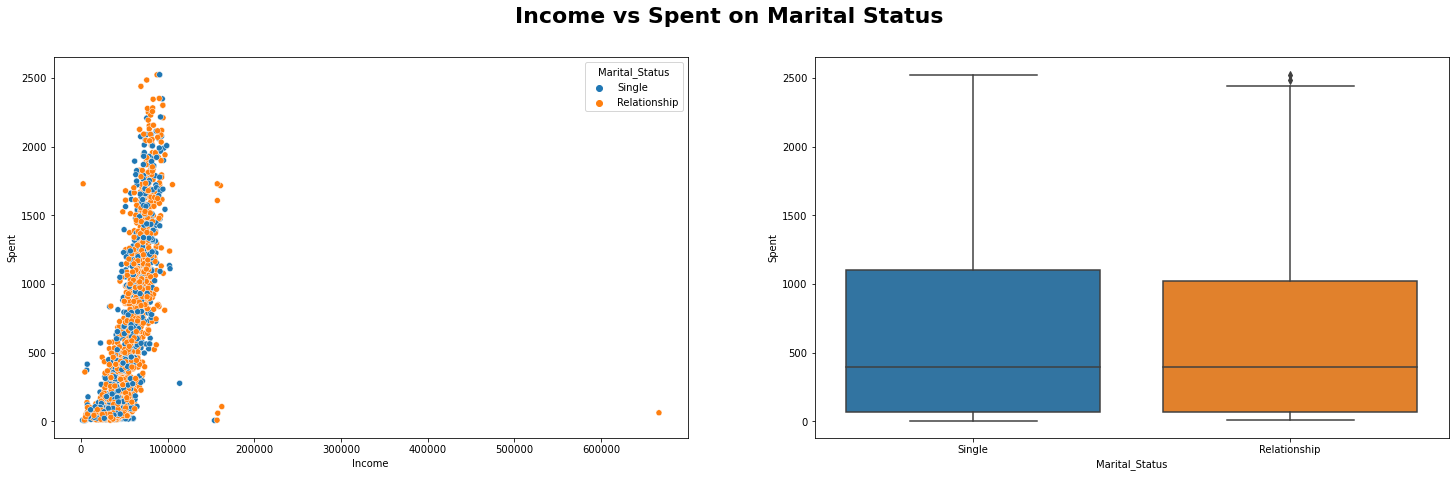

In [36]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,7))
fig.suptitle("Income vs Spent on Marital Status",size=22,weight="bold")


sns.scatterplot(x="Income",y="Spent",data=marketing_data, hue="Marital_Status", ax=ax1)

sns.boxplot(x="Marital_Status",y="Spent",data=marketing_data, ax=ax2);

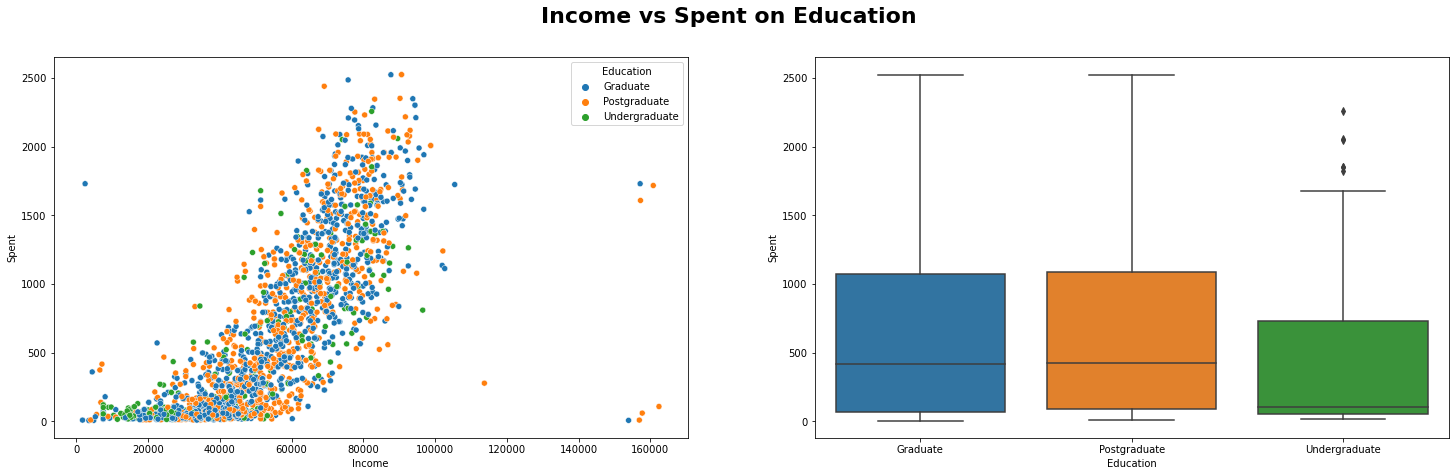

In [46]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,7))
fig.suptitle("Income vs Spent on Education",size=22,weight="bold")


sns.scatterplot(x="Income",y="Spent",data=marketing_data, hue="Education", ax=ax1)

sns.boxplot(x="Education",y="Spent",data=marketing_data, ax=ax2);

The maximum age here is 128. Since the age column is calculated based on today's date and the data is old. But, there may be some outliers as well.

In [64]:
#Dropping the outliers by setting a cap on Age and income. 
marketing_data = marketing_data[(marketing_data["Age"]<90)]
marketing_data = marketing_data[(marketing_data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(marketing_data))

The total number of data-points after removing the outliers are: 2236


<AxesSubplot:title={'center':'Correlation between values'}>

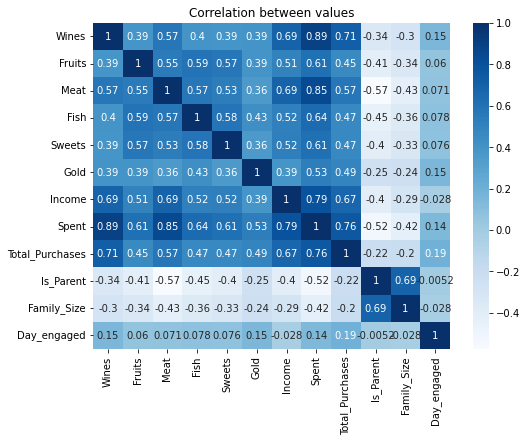

In [14]:
corr_data= marketing_data[["Wines","Fruits","Meat","Fish","Sweets","Gold","Income","Spent","Total_Purchases","Is_Parent","Family_Size","Day_engaged",]]

fig = plt.figure(figsize=(8,6))
plt.title('Correlation between values')
sns.heatmap(corr_data.corr(), annot=True, cmap="Blues")

Income is positively correlated with wine and meat consumption, and also total spent of a customer.
Total spent is negatively correlated with parenthood and family size which is unexpected.
There is no significant relationship between number of days that customers started to shop in the store and among other features.

In [15]:
fig = make_subplots(rows=2, cols=2, start_cell="bottom-left",
                   subplot_titles=("Age", "Income", "Family Size", "Children"))


fig.add_trace(go.Box(x=marketing_data.Age, name="Age",boxmean=True),row=1,col=1)

fig.add_trace(go.Box(x=marketing_data.Income,name="Income",boxmean=True),row=1, col=2)

fig.add_trace(go.Box(x=marketing_data.Family_Size,name="Family Size",boxmean=True),row=2, col=1)

fig.add_trace(go.Box(x=marketing_data.Children,name="Children",boxmean=True),row=2, col=2)

fig.show()

The average household size is 3. Customers with families generally have one child.
The average age of customers is 52. Customers are mostly adults over 25.
After removing the outliers, the average income value is 52 K, and the median of the income distribution is 51 K.

In [16]:
fig1 = px.box(marketing_data, x="Marital_Status_2", y="Spent", color="Education",
             notched=False, # used notched shape
             title="Total Spent by Marital Status & Education" # add day column to hover marketing_data
            )
fig2 = px.box(marketing_data, x="Marital_Status_2", y="Total_Purchases", color="Education",
             notched=False, # used notched shape
             title="Total Purchases by Marital Status & Education" # add day column to hover marketing_data
            )
fig1.show()
fig2.show()

There is a noticeable difference between medians of total spendings among families and others.

Customers with postgraduate degree are the customers who spend the most.

When we look at the second chart, we can say that the median difference in total purchasing varies less by education and marital status.

In [32]:
grouping_data = marketing_data[["Education","Marital_Status_2","Income","Children","Recency","Wines",
                     "Fruits","Meat","Fish","Sweets","Gold","Accepted_Campaigns","Total_Purchases",
                     "Spent","Day_engaged",'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                      'NumStorePurchases', 'NumWebVisitsMonth']].groupby(by=["Education","Marital_Status_2"]).mean().reset_index()
grouping_data

Education      Marital_Status_2        Income  Children    Recency  \
0       Graduate  Family with Children  46500.059627  1.313043  50.290683   
1       Graduate          Relationship  67152.138743  0.000000  45.371728   
2       Graduate                Single  65198.930769  0.000000  55.515385   
3   Postgraduate  Family with Children  48952.373387  1.374194  47.682258   
4   Postgraduate          Relationship  71712.988806  0.000000  51.716418   
5   Postgraduate                Single  67238.287129  0.000000  45.950495   
6  Undergraduate  Family with Children  38034.637931  1.247126  48.827586   
7  Undergraduate          Relationship  46757.922414  0.000000  45.620690   
8  Undergraduate                Single  58717.913043  0.000000  51.347826   

        Wines     Fruits        Meat       Fish     Sweets       Gold  \
0  220.103106  19.642236   97.493168  25.936646  20.782609  41.600000   
1  462.984293  57.633508  400.984293  90.916230  59.298429  75.115183   
2  421.146154  60.376923  363.046154  79.830769  56.107692  72.769231   
3  278.241935   9.948387   78.680645  14.356452  10.130645  29.625806   
4  636.537313  51.694030  401.649254  64.216418  46.537313  51.014925   
5  606.554455  44.722772  388.376238  71.851485  50.316832  51.702970   
6  116.034483  20.189655   51.425287  31.137931  21.563218  33.258621   
7  207.327586  34.620690  218.000000  66.655172  44.379310  53.793103   
8  364.521739  41.347826  334.260870  54.869565  55.521739  74.695652   

   Accepted_Campaigns  Total_Purchases        Spent  Day_engaged  \
0            0.180124        13.976398   425.557764   547.428571   
1            0.659686        17.801047  1146.931937   522.664921   
2            0.553846        17.169231  1053.276923   525.269231   
3            0.191935        14.283871   420.983871   515.617742   
4            0.634328        18.649254  1251.649254   548.708955   
5            0.613861        18.277228  1213.524752   528.534653   
6            0.114943        11.275862   273.609195   568.051724   
7            0.379310        14.000000   624.775862   618.689655   
8            0.652174        17.260870   925.217391   576.478261   

   NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  NumStorePurchases  \
0           2.787578         4.048447             1.881988           5.258385   
1           1.020942         4.418848             4.942408           7.418848   
2           1.230769         4.176923             4.707692           7.053846   
3           2.866129         4.101613             1.930645           5.385484   
4           1.179104         4.582090             5.425373           7.462687   
5           1.148515         4.762376             4.594059           7.772277   
6           2.609195         3.097701             1.224138           4.344828   
7           1.206897         3.724138             3.189655           5.879310   
8           1.173913         4.391304             4.260870           7.434783   

   NumWebVisitsMonth  
0           6.019876  
1           3.277487  
2           3.700000  
3           6.027419  
4           2.910448  
5           3.405941  
6           6.281609  
7           4.775862  
8           4.304348

Customers with postgraduate degree have the highest income.
Recency does not vary by education and marital status.
Wine consumption seems like highly correlated with marital status and education. It is highest at customers with postgraduate degree and who are not parents.
Meat consumption is seems like related with educational status and income level.

In [33]:
marketing_data.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age', 'Children', 'Family_Size', 'Is_Parent',
       'Spent', 'Accepted_Campaigns', 'Total_Purchases', 'Marital_Status_2',
       'Day_engaged'],
      dtype='object')

In [34]:
scatter = marketing_data[["Day_engaged","Spent","Total_Purchases"]]
# scatter matrix
fig = ff.create_scatterplotmatrix(scatter, diag='box',colormap='Portland',
                                  colormap_type='cat',
                                  height=700, width=700)
fig.show()

In [20]:
# prepare marketing_data frames

df = marketing_data.groupby(by=["Marital_Status_2"]).agg({"Income":np.mean,"Spent":np.mean}).reset_index()

y_income = [round(float(each)) for each in df.Income]
y_spent  = [round(float(each)) for each in df.Spent]
x_income = [each for each in df.Marital_Status_2]
x_spent  = [each for each in df.Marital_Status_2]

trace0 = go.Bar(
                x=y_income,
                y=x_income,
                marker=dict(color='rgba(171, 50, 96, 0.6)',line=dict(color='rgba(171, 50, 96, 1.0)',width=1)),
                name='Spent',
                orientation='h',
)
trace1 = go.Scatter(
                x=y_spent,
                y=x_spent,
                mode='lines+markers',
                line=dict(color='rgb(63, 72, 204)'),
                name='Income',
)
layout = dict(
                title='Income & Total Spent by Marital Status',
                yaxis=dict(showticklabels=True,domain=[0, 0.85]),
                yaxis2=dict(showline=True,showticklabels=False,linecolor='rgba(102, 102, 102, 0.8)',linewidth=2,domain=[0, 0.85]),
                xaxis=dict(zeroline=False,showline=False,showticklabels=True,showgrid=True,domain=[0, 0.42]),
                xaxis2=dict(zeroline=False,showline=False,showticklabels=True,showgrid=True,domain=[0.47, 1],side='top',dtick=25),
                legend=dict(x=0.029,y=1.038,font=dict(size=10) ),
                margin=dict(l=200, r=20,t=70,b=70),
                paper_bgcolor='rgb(248, 248, 255)',
                plot_bgcolor='rgb(248, 248, 255)'
)

annotations = []
y_s = np.round(y_income, decimals=2)
y_nw = np.rint(y_spent)
# Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x_income):
    # labeling the scatter savings
    annotations.append(dict(xref='x2', yref='y2', y=xd, x=ydn - 4,text='{:,}'.format(ydn),font=dict(family='Arial', size=12,color='rgb(63, 72, 204)'),showarrow=False))
    # labeling the bar net worth
    annotations.append(dict(xref='x1', yref='y1', y=xd, x=yd + 3,text=str(yd),font=dict(family='Arial', size=12,color='rgb(171, 50, 96)'),showarrow=False))

layout['annotations'] = annotations


# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                          shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(layout)

fig.show()

As seen above, customers who are not parents have higher income and spending than others.

In [22]:
df = marketing_data.groupby(by=["Education"]).agg({"Income":np.mean,"Spent":np.mean}).reset_index()

y_income = [round(float(each)) for each in df.Income]
y_spent  = [round(float(each)) for each in df.Spent]
x_income = [each for each in df.Education]
x_spent  = [each for each in df.Education]

trace0 = go.Bar(
                x=y_income,
                y=x_income,
                marker=dict(color='rgba(171, 50, 96, 0.6)',line=dict(color='rgba(171, 50, 96, 1.0)',width=1)),
                name='Spent',
                orientation='h',
)
trace1 = go.Scatter(
                x=y_spent,
                y=x_spent,
                mode='lines+markers',
                line=dict(color='rgb(63, 72, 204)'),
                name='Income',
)
layout = dict(
                title='Income & Total Spent by Education',
                yaxis=dict(showticklabels=True,domain=[0, 0.85]),
                yaxis2=dict(showline=True,showticklabels=False,linecolor='rgba(102, 102, 102, 0.8)',linewidth=2,domain=[0, 0.85]),
                xaxis=dict(zeroline=False,showline=False,showticklabels=True,showgrid=True,domain=[0, 0.42]),
                xaxis2=dict(zeroline=False,showline=False,showticklabels=True,showgrid=True,domain=[0.47, 1],side='top',dtick=25),
                legend=dict(x=0.029,y=1.038,font=dict(size=10) ),
                margin=dict(l=200, r=20,t=70,b=70),
                paper_bgcolor='rgb(248, 248, 255)',
                plot_bgcolor='rgb(248, 248, 255)'
)

annotations = []
y_s = np.round(y_income, decimals=2)
y_nw = np.rint(y_spent)
# Adding labels
for ydn, yd, xd in zip(y_nw, y_s, x_income):
    # labeling the scatter savings
    annotations.append(dict(xref='x2', yref='y2', y=xd, x=ydn - 4,text='{:,}'.format(ydn),font=dict(family='Arial', size=12,color='rgb(63, 72, 204)'),showarrow=False))
    # labeling the bar net worth
    annotations.append(dict(xref='x1', yref='y1', y=xd, x=yd + 3,text=str(yd),font=dict(family='Arial', size=12,color='rgb(171, 50, 96)'),showarrow=False))

layout['annotations'] = annotations


# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, specs=[[{}, {}]], shared_xaxes=True,
                          shared_yaxes=False, vertical_spacing=0.001)

fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)

fig['layout'].update(layout)

fig.show()

In [25]:
#Single customers

data_single = marketing_data[marketing_data.Marital_Status_2 == "Single"]

trace_single_1 = go.Box(
    x=data_single.Wines,
    name = "Wines",
    marker=dict(color='rgba(171, 50, 96, 0.6)'))
trace_single_2 = go.Box(
    x=data_single.Fruits,
    name = "Fruits",
    marker=dict(color='rgba(12, 50, 196, 0.6)'))
trace_single_3 = go.Box(
    x=data_single.Meat,
    name = "Meat",
    marker=dict(color='rgba(0, 255, 200, 0.8)'))
trace_single_4 = go.Box(
    x=data_single.Fish,
    name = "Fish",
    marker=dict(color='rgb(12, 128, 128)'))
trace_single_5 = go.Box(
    x=data_single.Sweets,
    name = "Sweets",
    marker=dict(color='rgba(255, 255, 128, 0.5)'))
trace_single_6 = go.Box(
    x=data_single.Gold,
    name = "Gold",
    marker=dict(color='rgba(255, 128, 2, 0.8)'))

data_single_ = [trace_single_1, trace_single_2, trace_single_3,trace_single_4,trace_single_5,trace_single_6]
layout = go.Layout(barmode='overlay',
                   title=' Amount Spend of Different Products for Singles',
                   xaxis=dict(title='Amount Spend'),
                   yaxis=dict( title='Product'),
)
fig1 = go.Figure(data=data_single_, layout=layout)

fig1.show()


In [26]:
#Customers in a relationship

data_relationship = marketing_data[marketing_data.Marital_Status_2 == "Relationship"]

trace_relationship_1 = go.Box(
    x=data_relationship.Wines,
    name = "Wines",
    marker=dict(color='rgba(171, 50, 96, 0.6)'))
trace_relationship_2 = go.Box(
    x=data_relationship.Fruits,
    name = "Fruits",
    marker=dict(color='rgba(12, 50, 196, 0.6)'))
trace_relationship_3 = go.Box(
    x=data_relationship.Meat,
    name = "Meat",
    marker=dict(color='rgba(0, 255, 200, 0.8)'))
trace_relationship_4 = go.Box(
    x=data_relationship.Fish,
    name = "Fish",
    marker=dict(color='rgb(12, 128, 128)'))
trace_relationship_5 = go.Box(
    x=data_relationship.Sweets,
    name = "Sweets",
    marker=dict(color='rgba(255, 255, 128, 0.5)'))
trace_relationship_6 = go.Box(
    x=data_relationship.Gold,
    name = "Gold",
    marker=dict(color='rgba(255, 128, 2, 0.8)'))

data_relationship_ = [trace_relationship_1, trace_relationship_2, trace_relationship_3,trace_relationship_4,trace_relationship_5,trace_relationship_6]
layout2 = go.Layout(barmode='overlay',
                   title=' Amount Spend of Different Products for Customers in a Relationship',
                   xaxis=dict(title='Amount Spend'),
                   yaxis=dict( title='Product'),
)
fig2 = go.Figure(data=data_relationship_, layout=layout2)



fig2.show()

In [27]:
#Customers in a relationship

data_families = marketing_data[marketing_data.Marital_Status_2 == "Family with Children"]

trace_families_1 = go.Box(
    x=data_families.Wines,
    name = "Wines",
    marker=dict(color='rgba(171, 50, 96, 0.6)'))
trace_families_2 = go.Box(
    x=data_families.Fruits,
    name = "Fruits",
    marker=dict(color='rgba(12, 50, 196, 0.6)'))
trace_families_3 = go.Box(
    x=data_families.Meat,
    name = "Meat",
    marker=dict(color='rgba(0, 255, 200, 0.8)'))
trace_families_4 = go.Box(
    x=data_families.Fish,
    name = "Fish",
    marker=dict(color='rgb(12, 128, 128)'))
trace_families_5 = go.Box(
    x=data_families.Sweets,
    name = "Sweets",
    marker=dict(color='rgba(255, 255, 128, 0.5)'))
trace_families_6 = go.Box(
    x=data_families.Gold,
    name = "Gold",
    marker=dict(color='rgba(255, 128, 2, 0.8)'))

data_families_ = [trace_families_1, trace_families_2, trace_families_3,trace_families_4,trace_families_5,trace_families_6]
layout3 = go.Layout(barmode='overlay',
                   title=' Amount Spend of Different Products for Customers with children',
                   xaxis=dict(title='Amount Spend'),
                   yaxis=dict( title='Product'),
)
fig3 = go.Figure(data=data_families_, layout=layout3)

fig3.show()

In [36]:
model_data= marketing_data.copy()

categorical_cols = list((model_data.dtypes == 'object')[(model_data.dtypes == 'object')].index)

#1. Label Encoding
LE=LabelEncoder()
for i in categorical_cols:
    model_data[i]=model_data[[i]].apply(LE.fit_transform)

In [37]:
cols_del = ['Marital_Status',
            'Teenhome',
            "Kidhome",
            'AcceptedCmp3',
            'AcceptedCmp4',
            'AcceptedCmp5',
            'AcceptedCmp1',
            'AcceptedCmp2',
            'Complain',
            'Response']

model_data = model_data.drop(cols_del, axis=1)

scaler = StandardScaler()
scaler.fit(model_data)

model_data_2 = pd.DataFrame(scaler.transform(model_data),columns= model_data.columns )

In [38]:
model_data_2.head()

Education    Income   Recency     Wines    Fruits      Meat      Fish  \
0   -0.89438  0.288947  0.306856  0.983228  1.554170  1.679746  2.461068   
1   -0.89438 -0.262003 -0.383971 -0.871064 -0.636431 -0.713455 -0.650414   
2   -0.89438  0.918423 -0.798467  0.362159  0.572177 -0.177201  1.344595   
3   -0.89438 -1.182183 -0.798467 -0.871064 -0.560893 -0.651409 -0.503991   
4    0.57070  0.296187  1.550344 -0.389661  0.421101 -0.217088  0.154911   

     Sweets      Gold  NumDealsPurchases  ...  NumWebVisitsMonth       Age  \
0  1.475396  0.845669           0.348738  ...           0.692865  1.016868   
1 -0.631638 -0.729742          -0.168700  ...          -0.131421  1.273264   
2 -0.147262 -0.038098          -0.686137  ...          -0.543564  0.333146   
3 -0.583200 -0.748954          -0.168700  ...           0.280722 -1.290693   
4 -0.001950 -0.556831           1.383614  ...          -0.131421 -1.034298   

   Children  Family_Size  Is_Parent     Spent  Accepted_Campaigns  \
0 -1.264308    -1.758810  -1.584362  1.680176           -0.438933   
1  1.395139     0.445618   0.631169 -0.962202           -0.438933   
2 -1.264308    -0.656596  -1.584362  0.282541           -0.438933   
3  0.065416     0.445618   0.631169 -0.918994           -0.438933   
4  0.065416     0.445618   0.631169 -0.305762           -0.438933   

   Total_Purchases  Marital_Status_2  Day_engaged  
0         1.319340          2.343838     1.975467  
1        -1.155857         -0.583178    -1.667017  
2         0.798246          0.880330    -0.172996  
3        -0.895310         -0.583178    -1.925349  
4         0.537699         -0.583178    -0.823131  

[5 rows x 23 columns]

In [39]:
pca = PCA(n_components=3)
pca.fit(model_data_2)
PCA_ds = pd.DataFrame(pca.transform(model_data_2), columns=(["pc1","pc2", "pc3"]))
PCA_ds.describe().T

#Ploting result data
x =PCA_ds["pc1"]
y =PCA_ds["pc2"]
z =PCA_ds["pc3"]


fig = go.Figure(data=[go.Scatter3d(
    x=x,y=y,z=z,mode='markers',
    marker=dict(size=6,color=x,opacity=0.8))])

# tight layout
fig.update_layout( title={'text': "3D scatterplot of size-reduced data",'y':0.9,
        'x':0.5,'xanchor': 'center','yanchor': 'top'},
                  margin=dict(l=200, r=220, b=0, t=0))
fig.show()

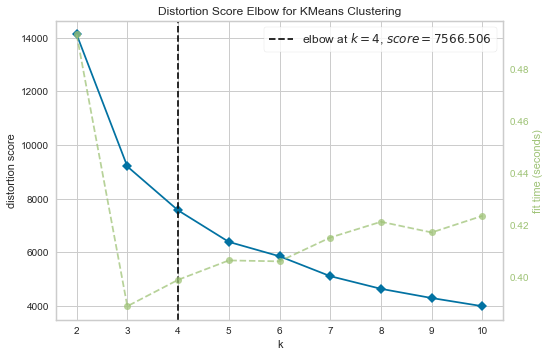

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [40]:
from yellowbrick.cluster import KElbowVisualizer
elbow_plot = KElbowVisualizer(KMeans(), k=10)
elbow_plot.fit(PCA_ds)
elbow_plot.show()

In [41]:
#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(model_data_2)
PCA_ds = pd.DataFrame(pca.transform(model_data_2), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2236.0 -6.951307e-17  2.971957 -5.448192 -2.710196 -0.796720  2.456567   
col2  2236.0  3.853010e-17  1.726298 -4.748577 -1.172338 -0.228878  1.241697   
col3  2236.0  6.355481e-18  1.180190 -3.647090 -0.838410 -0.024841  0.798455   

           max  
col1  8.104564  
col2  6.472244  
col3  6.714659

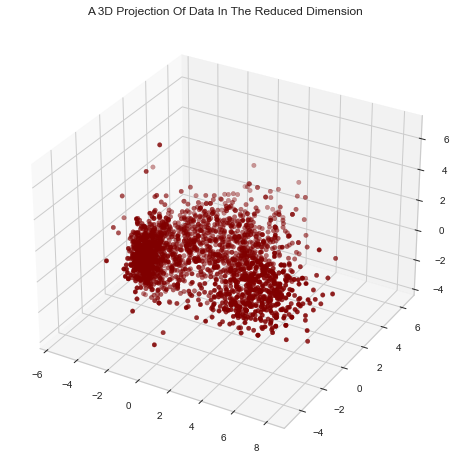

In [42]:
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


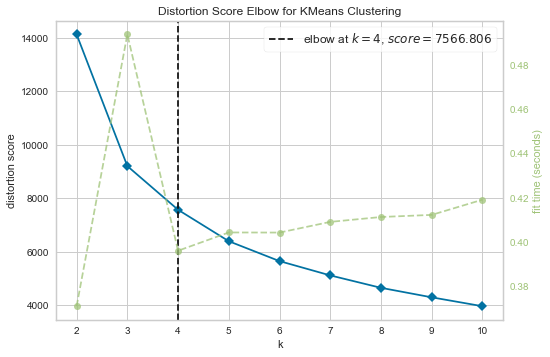

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [43]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [49]:
from sklearn.cluster import KMeans
import numpy as np

# Sample data

# Create a KMeans model with 2 clusters
kmeans = KMeans(n_clusters=4)

# Fit the model to the data
kmeans.fit(PCA_ds)

# Predict the cluster for each datapoint
predictions = kmeans.predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
model_data["Clusters"]= yhat_AC

In [51]:
model_data["Clusters"].value_counts()

2    839
0    763
1    488
3    146
Name: Clusters, dtype: int64

In [44]:
#Initiating the Agglomerative Clustering model 
AC = K(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
model_data["Clusters"]= yhat_AC

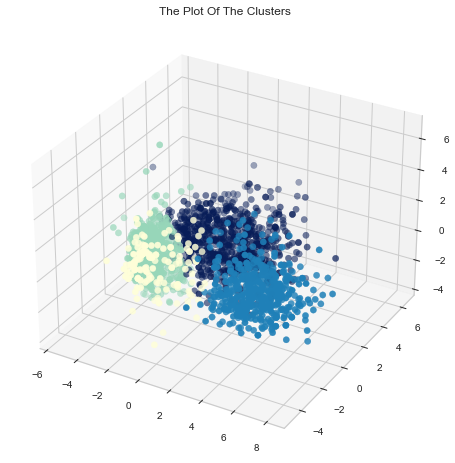

In [52]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap ='YlGnBu_r' )
ax.set_title("The Plot Of The Clusters")
plt.show()

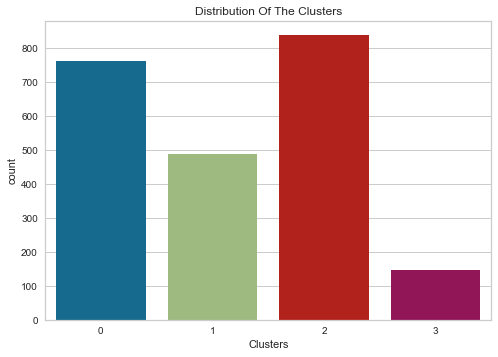

In [57]:
#pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=model_data["Clusters"])
pl.set_title("Distribution Of The Clusters")
plt.show()

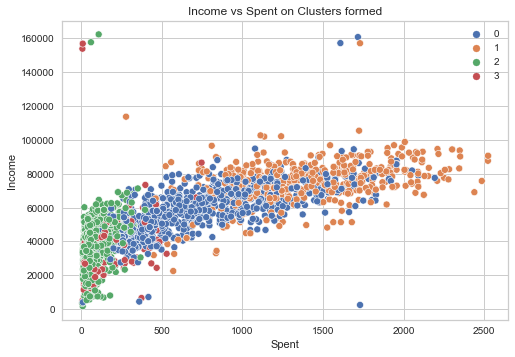

In [58]:
pl = sns.scatterplot(data = model_data,x=model_data["Spent"], y=model_data["Income"],hue=model_data["Clusters"],palette='deep')
pl.set_title("Income vs Spent on Clusters formed")
plt.legend()
plt.show()

In [98]:
model_data.columns

Index(['Education', 'Income', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish',
       'Sweets', 'Gold', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age',
       'Children', 'Family_Size', 'Is_Parent', 'Spent', 'Accepted_Campaigns',
       'Total_Purchases', 'Marital_Status_2', 'Day_engaged', 'Clusters'],
      dtype='object')

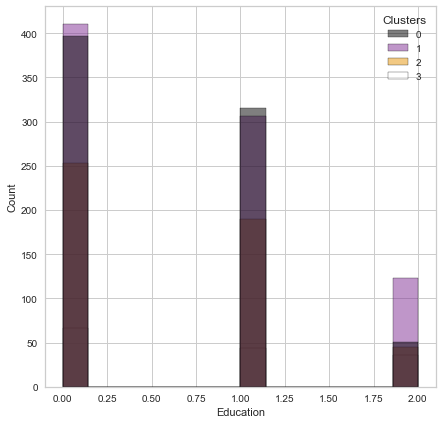

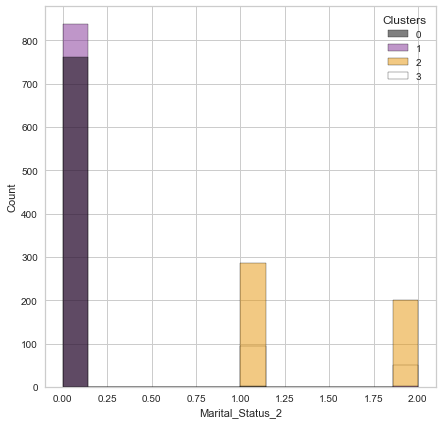

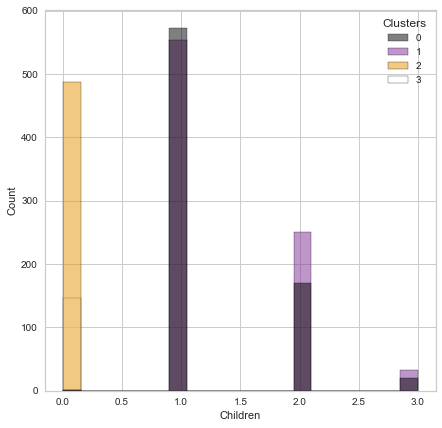

In [104]:
object_cols=['Education','Marital_Status_2','Children']
for column in object_cols:
    plt.figure(figsize=(7,7))
    sns.histplot(x=model_data[column], hue =model_data["Clusters"],palette='CMRmap')
    plt.show();

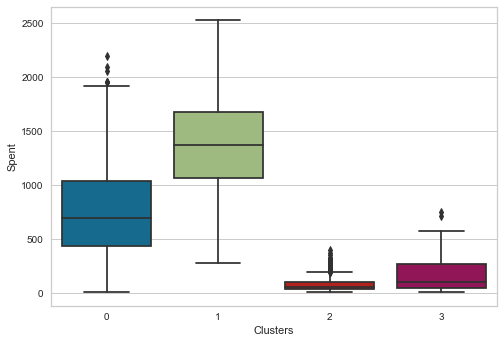

In [61]:
plt.figure()
pl=sns.boxplot(x=model_data["Clusters"], y=model_data["Spent"])
plt.show()

In [144]:
model_data_2.columns

Index(['Education', 'Income', 'Recency', 'Wines', 'Fruits', 'Meat', 'Fish',
       'Sweets', 'Gold', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age',
       'Children', 'Family_Size', 'Is_Parent', 'Spent', 'Accepted_Campaigns',
       'Total_Purchases', 'Marital_Status_2', 'Day_engaged', 'Clusters'],
      dtype='object')

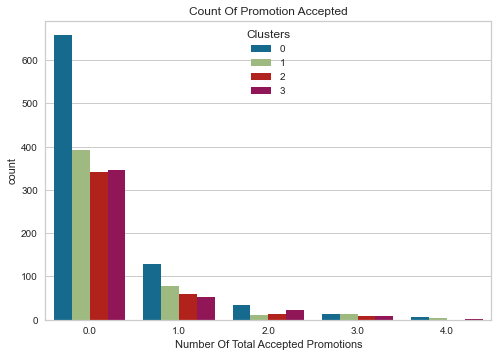

In [145]:
model_data_2["Total_Promos"] = marketing_data["AcceptedCmp1"]+ marketing_data["AcceptedCmp2"]+ marketing_data["AcceptedCmp3"]+ marketing_data["AcceptedCmp4"]+ marketing_data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=model_data_2["Total_Promos"],hue=model_data_2["Clusters"])
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

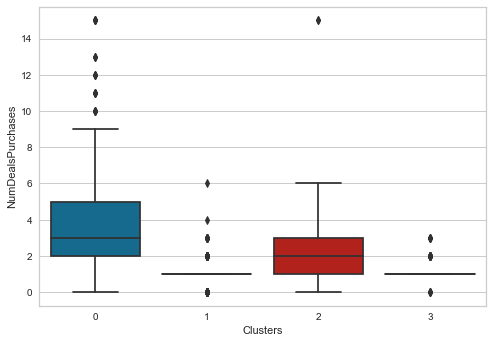

In [63]:
plt.figure()
pl=sns.boxplot(y=model_data["NumDealsPurchases"],x=model_data["Clusters"])
#pl.set_title("Deals Purchased")
plt.show()

<Figure size 576x396 with 0 Axes>

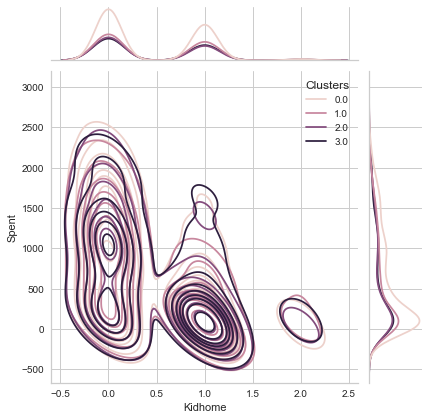

<Figure size 576x396 with 0 Axes>

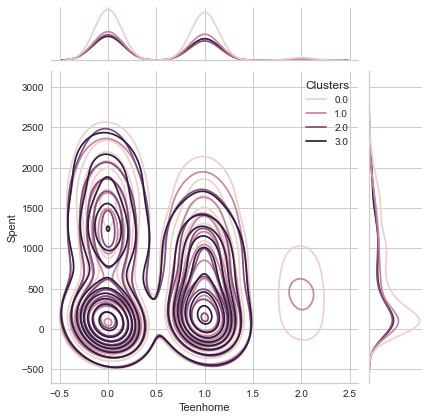

<Figure size 576x396 with 0 Axes>

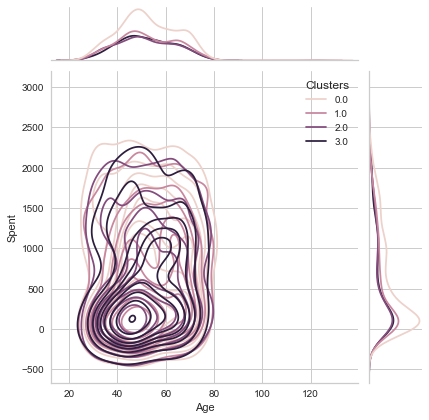

<Figure size 576x396 with 0 Axes>

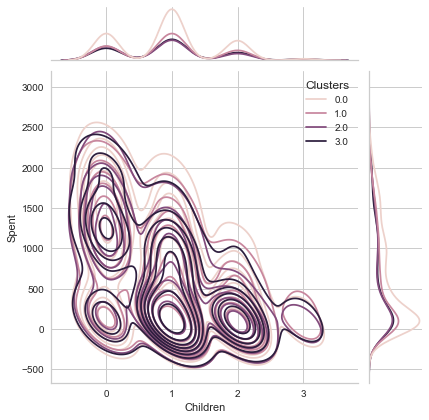

<Figure size 576x396 with 0 Axes>

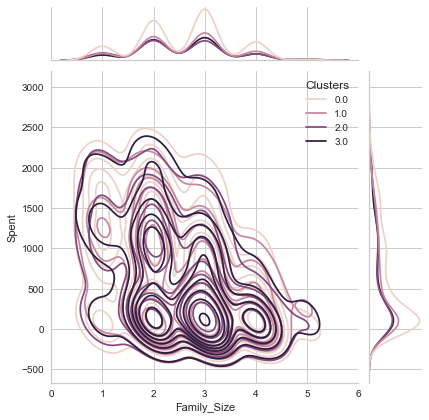

<Figure size 576x396 with 0 Axes>

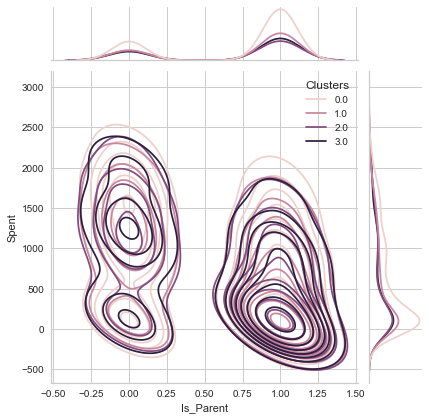

TypeError: The x variable is categorical, but one of ['numeric', 'datetime'] is required

<Figure size 576x396 with 0 Axes>

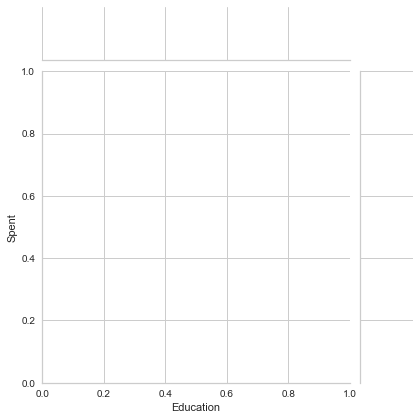

In [159]:
Personal = [ "Kidhome","Teenhome", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=marketing_data[i], y=marketing_data["Spent"], hue =model_data_2["Clusters"], kind="kde")
    plt.show()

<AxesSubplot:xlabel='Clusters', ylabel='Count'>

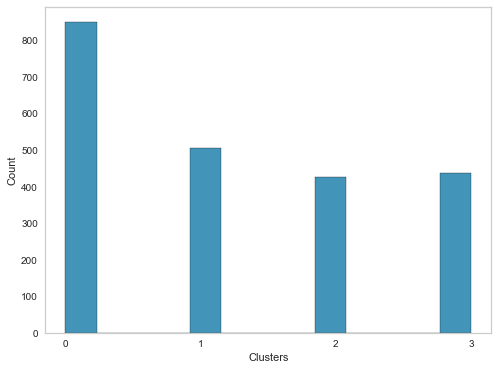

In [166]:
plt.figure(figsize=(8,6))
plt.xticks(range(4))
plt.grid(False)
sns.histplot(model_data_2["Clusters"])
#print(S + f"Seem like cluster 1 is the main type of customer, while cluster 3 is a very rare customer. \
#Indeed, they both represent {model_data_2['Clusters'].value_counts()[1] / model_data_2.shape[1]:.0f}% and {model_data_2['Clusters'].value_counts()[3] / model_data_2.shape[1]:.0f}% of the customers.");

In [158]:
marketing_data.columns

Index(['Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome',
       'Recency', 'Wines', 'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold',
       'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
       'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3',
       'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2',
       'Complain', 'Response', 'Age', 'Children', 'Family_Size', 'Is_Parent',
       'Spent', 'Accepted_Campaigns', 'Total_Purchases', 'Marital_Status_2',
       'Day_engaged'],
      dtype='object')